# Figures for Keizer et al. (2023): "The acceleration of sea-level rise along the coast of the Netherlands started in the 1960s"

### Overview of this notebook
- Fig. 1: setting & pressure correlation (partly created in `obtain_pressure_gradient.ipynb`)
- Fig. 2: sea level time series
- Fig. 3: wind contribution to sea level rise
- Fig. 4: rates of sea level rise
- Fig. A1: multidecadal variability (created in `wind-driven-sea-level_sst_analysis.ipynb`)


In [110]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm, linregress

import local_functions as loc

# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [111]:
region = 'Netherlands' # Choose from 'Netherlands', 'Belgium', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden'
bootsize = 10000 # Choose from 100, 1000, 10000
output_dir = f'./outputs/{region}/'

if os.path.exists(output_dir)==False:
    os.makedirs(output_dir)

if os.path.exists(output_dir+str(bootsize))==False:
    os.makedirs(output_dir+str(bootsize))

### Read rates data

In [112]:
tg_df = pd.read_csv(f'{output_dir}data_tide_gauges.csv')

res_nr = pd.read_csv(f'{output_dir}results_NoRegressor.csv')
res_nt = pd.read_csv(f'{output_dir}results_NodalTide.csv')
res_na = pd.read_csv(f'{output_dir}results_NearestPointAverage2.csv')
res_pd = pd.read_csv(f'{output_dir}results_PressureDifference.csv')

for df in [tg_df, res_nr, res_nt, res_na, res_pd]:
    df.set_index('time', inplace=True)

In [113]:
rates_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_NoRegressor.csv')
rates_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_NodalTide.csv')
rates_na = pd.read_csv(f'{output_dir}{bootsize}/rates_NearestPointAverage2.csv')
rates_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_PressureDifference.csv')

rates_q_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NoRegressor.csv')
rates_q_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NodalTide.csv')
rates_q_na = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NearestPointAverage2.csv')
rates_q_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_PressureDifference.csv')

for df in [rates_nr, rates_nt, rates_na, rates_pd,
           rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd,]:
    df.set_index('time', inplace=True)

In [114]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_pd = rates_pd.std(axis=1)

In [115]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (velocity)', 
              'Trend, nodal tide and wind (pressure)']

short_names = ['Tr', 'TrNc', 'TrNcW', 'TrNcPd']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(4)]

### Read data nodal tides

In [116]:
nodal = pd.read_csv(f'{output_dir}NodalTide.csv').set_index('time')
nodal_residuals = pd.read_csv(f'{output_dir}NodalTideResiduals.csv').set_index('time')

## Fig. 1: Overview maps
- Fig. 1a is 
- Fig. 1b is created in `obtain_pressure_gradient.ipynb`

## Fig. 2: sea level time series

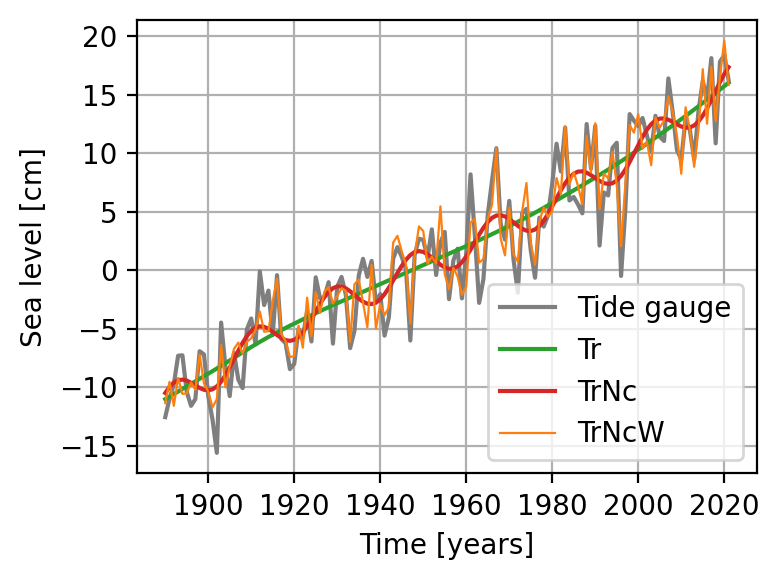

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_na.total.plot(label=short_names[2], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
# ax.grid(True)
ax.set_xticks(np.arange(1900,2021,20))
ax.grid(axis='x', which='major')
ax.grid(axis='y', which='major')
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/TideGauge_StatModels.pdf', dpi=150)

## Fig. 3: Wind contribution to sea level

In [118]:
wind_rec = pd.read_csv(f'{output_dir}/WindInfluence.csv')
wind_rec.set_index('time', inplace=True)

In [119]:
# Estimate the linear trend for different periods

mid_point = int(len(wind_rec.index)/2)
print(mid_point)

lin_trend_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[mid_point:-1]).slope*10, 2)

lin_trend_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).slope*10, 2)

93


/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_32958/1830290700.py:37: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


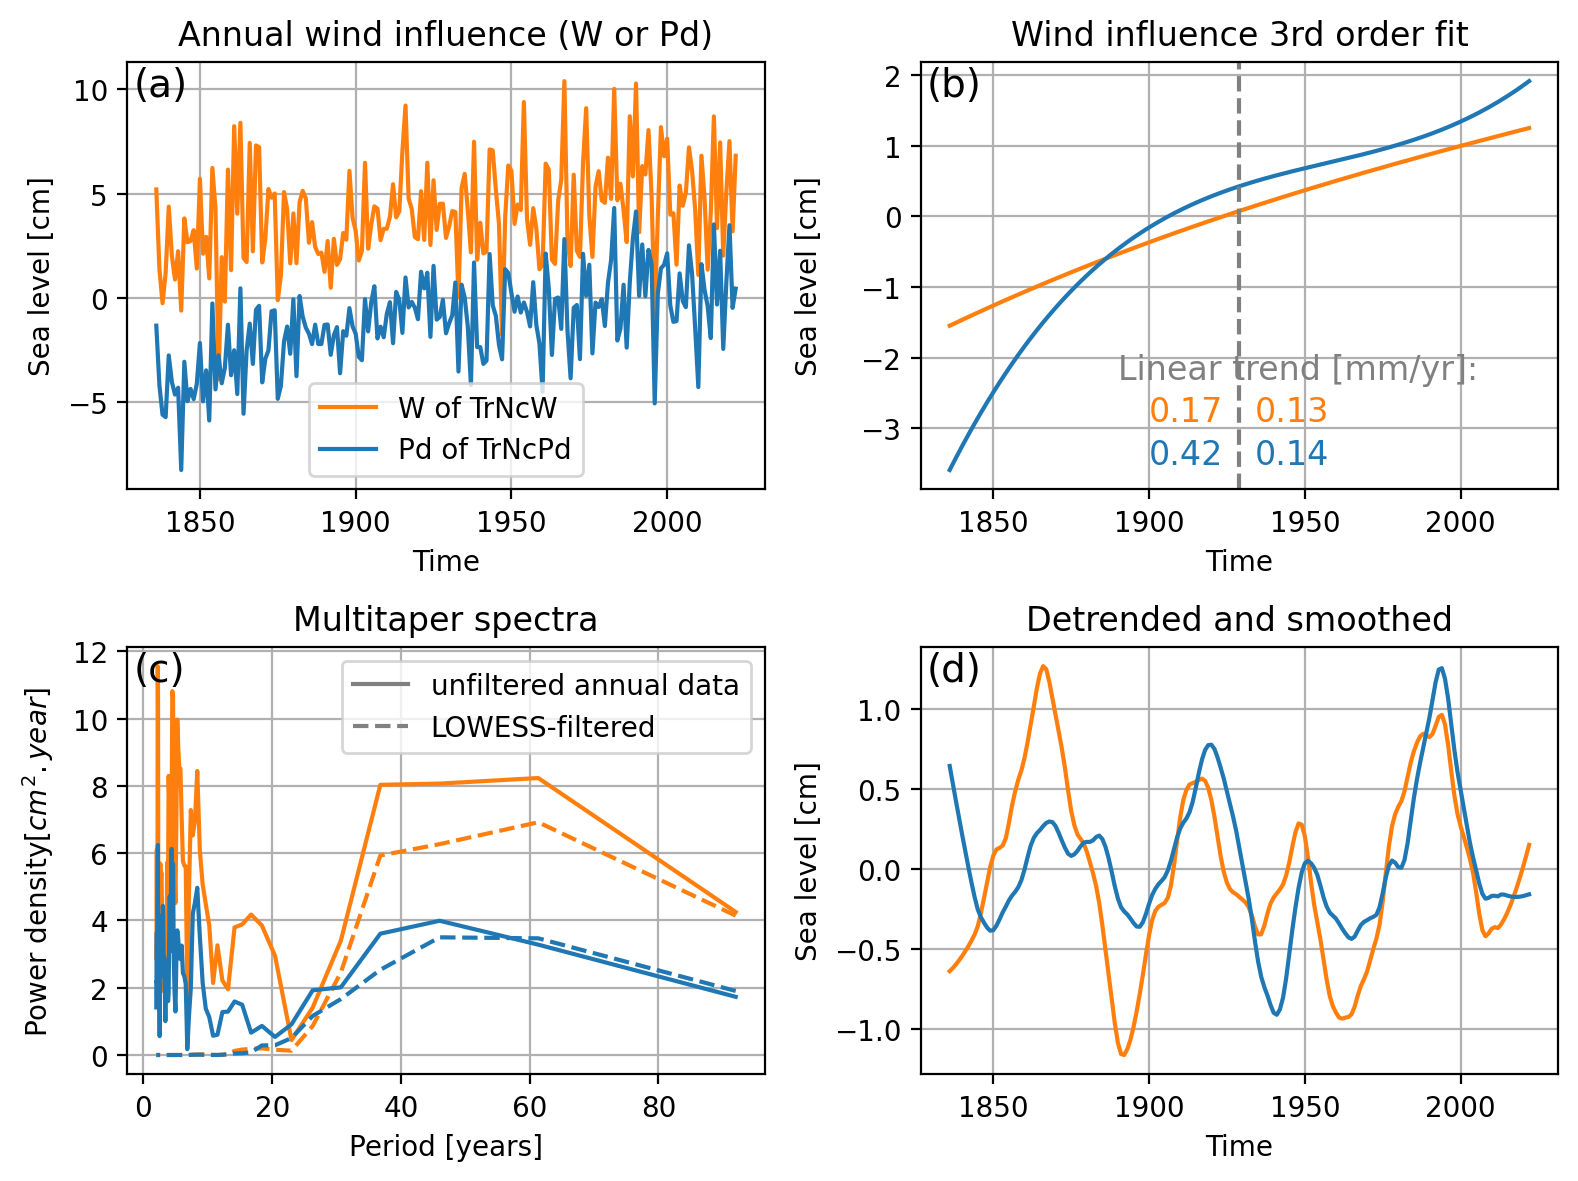

In [124]:
fig, ax = plt.subplots(2, 2, figsize=(8,6)) #14, 10

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']


# Panel 1
wind_rec[['NearestPointAverage2', 'PressureDifference']].plot(ax=ax[0,0], color=[colors[2], colors[3]])

ax[0,0].legend(['W of TrNcW', 'Pd of TrNcPd'])
ax[0,0].set_title('Annual wind influence (W or Pd)')
ax[0,0].set_ylabel('Sea level [cm]')
ax[0,0].set_xlabel('Time')


# Panel 2
(wind_rec['NearestPointAverage2_trend']-wind_rec['NearestPointAverage2_trend'].mean() ).plot(ax=ax[0,1], color=colors[2])
(wind_rec['PressureDifference_trend']-wind_rec['PressureDifference_trend'].mean() ).plot(ax=ax[0,1], color=colors[3])                                                                                                          

ax[0,1].text(1900, -2.9, lin_trend_na1, size=12, color=colors[2])
ax[0,1].text(1934, -2.9, lin_trend_na2, size=12, color=colors[2])

ax[0,1].text(1900, -3.5, lin_trend_pd1, size=12, color=colors[3])
ax[0,1].text(1934, -3.5, lin_trend_pd2, size=12, color=colors[3])

ax[0,1].text(1890, -2.3, 'Linear trend [mm/yr]:', size=12, color='grey')

ax[0,1].axvline(x=wind_rec.index[mid_point], color='grey', linestyle='--')

ax[0,1].set_title('Wind influence 3rd order fit')
ax[0,1].set_ylabel('Sea level [cm]')
ax[0,1].set_xlabel('Time')

# Panel 3
xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2], linestyle = 'dashed')

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_dt'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3], linestyle = 'dashed')

l1, = ax[1,0].plot([],[], c='grey', label='unfiltered annual data')
l2, = ax[1,0].plot([],[], c='grey', ls='--', label='LOWESS-filtered')
ax[1,0].legend(handles=[l1,l2])

ax[1,0].set_title('Multitaper spectra')
ax[1,0].set_ylabel('Power density'+r'$[cm^2.year]$')
ax[1,0].set_xlabel('Period [years]')

# Panel 4
wind_rec[['NearestPointAverage2_lowess', 'PressureDifference_lowess']].plot(ax=ax[1,1], color=[colors[2], colors[3]])

ax[1,1].set_title('Detrended and smoothed')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Sea level [cm]')

ax[1,1].get_legend().remove()

for idx in range(4):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()
fig.align_ylabels()

plt.savefig(f'./figures/{region}/WindInfluenceComp_lowess21.pdf', dpi=150)

- maybe forgo headings altogether


## Fig. 4: Rate of sea level rise

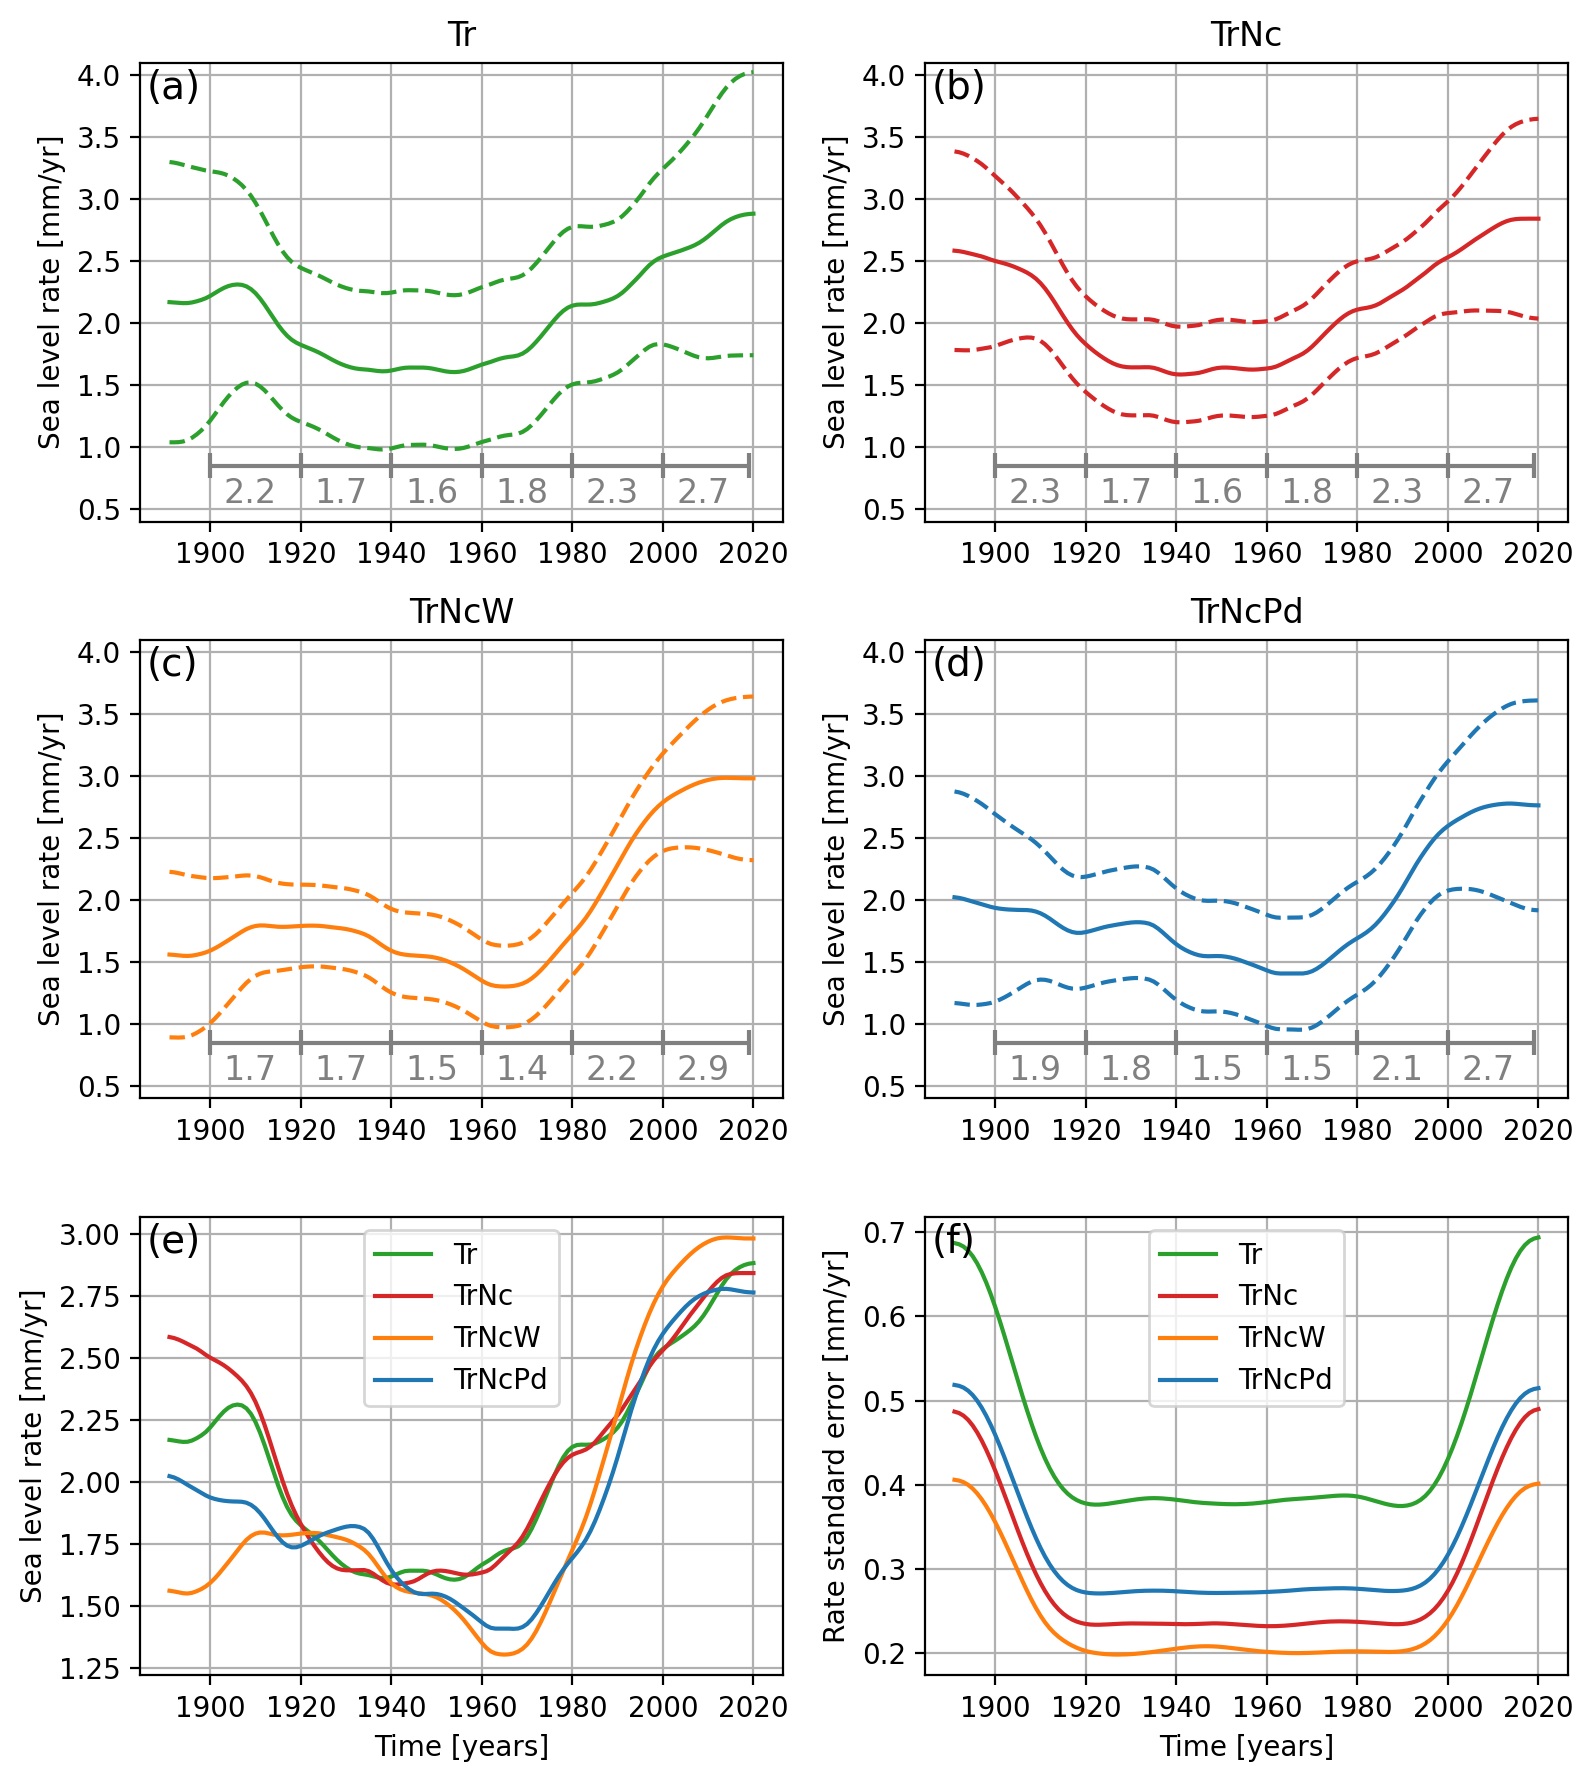

In [121]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]

fig, ax = plt.subplots(3, 2, figsize=(8,9))

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    
    res['0.5'].plot(ax=ax.flat[idx], title=short_names[idx], color=colors[idx])
    res['0.05'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    res['0.95'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    
    ax.flat[idx].set_xlabel('')
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([0.4, 4.1])
    # ax.flat[idx].grid(True)
    ax.flat[idx].text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, 
                      size=14)
    
    ax.flat[idx].hlines(y=0.85, xmin=list_st[0], xmax=list_st[5]+19, 
                        color='grey', linestyle='-')
    #ax.flat[idx].hlines(y=0.85, xmin=list_st[5], xmax=list_st[5]+19, 
    #                    color='grey', linestyle='-')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
        ax.flat[idx].text(st+3, 0.55, avg_rate, size=12, color='grey')
        ax.flat[idx].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', 
                            linestyle='-')
    ax.flat[idx].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')

rates_q_nr['0.5'].plot(ax=ax.flat[4], color=colors[0], label=short_names[0])
rates_q_nt['0.5'].plot(ax=ax.flat[4], color=colors[1], label=short_names[1])
rates_q_na['0.5'].plot(ax=ax.flat[4], color=colors[2], label=short_names[2])
rates_q_pd['0.5'].plot(ax=ax.flat[4], color=colors[3], label=short_names[3])

ax.flat[4].set_ylabel('Sea level rate [mm/yr]')
ax.flat[4].set_xlabel('Time [years]')
ax.flat[4].legend()
# ax.flat[4].grid(True)
ax.flat[4].text(0.01, 0.92, panels[4], transform=ax.flat[4].transAxes, size=14)

ser_nr.plot(ax=ax.flat[5], color=colors[0], label=short_names[0])
ser_nt.plot(ax=ax.flat[5], color=colors[1], label=short_names[1])
ser_na.plot(ax=ax.flat[5], color=colors[2], label=short_names[2])
ser_pd.plot(ax=ax.flat[5], color=colors[3], label=short_names[3])

ax.flat[5].set_ylabel('Rate standard error [mm/yr]')
ax.flat[5].set_xlabel('Time [years]')
ax.flat[5].legend()
# ax.flat[5].grid(True)
ax.flat[5].text(0.01, 0.92, panels[5], transform=ax.flat[5].transAxes, size=14)

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(np.arange(1900,2021,20))
        ax[i,j].grid(axis='x', which='major')
        ax[i,j].grid(axis='y', which='major')

fig.tight_layout()
plt.savefig(f'./figures/{region}/{bootsize}/RateSeaLevelTrend.pdf', dpi=150)

## Fig. A1: Nodal effects on sea level

/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_32958/3339097624.py:20: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


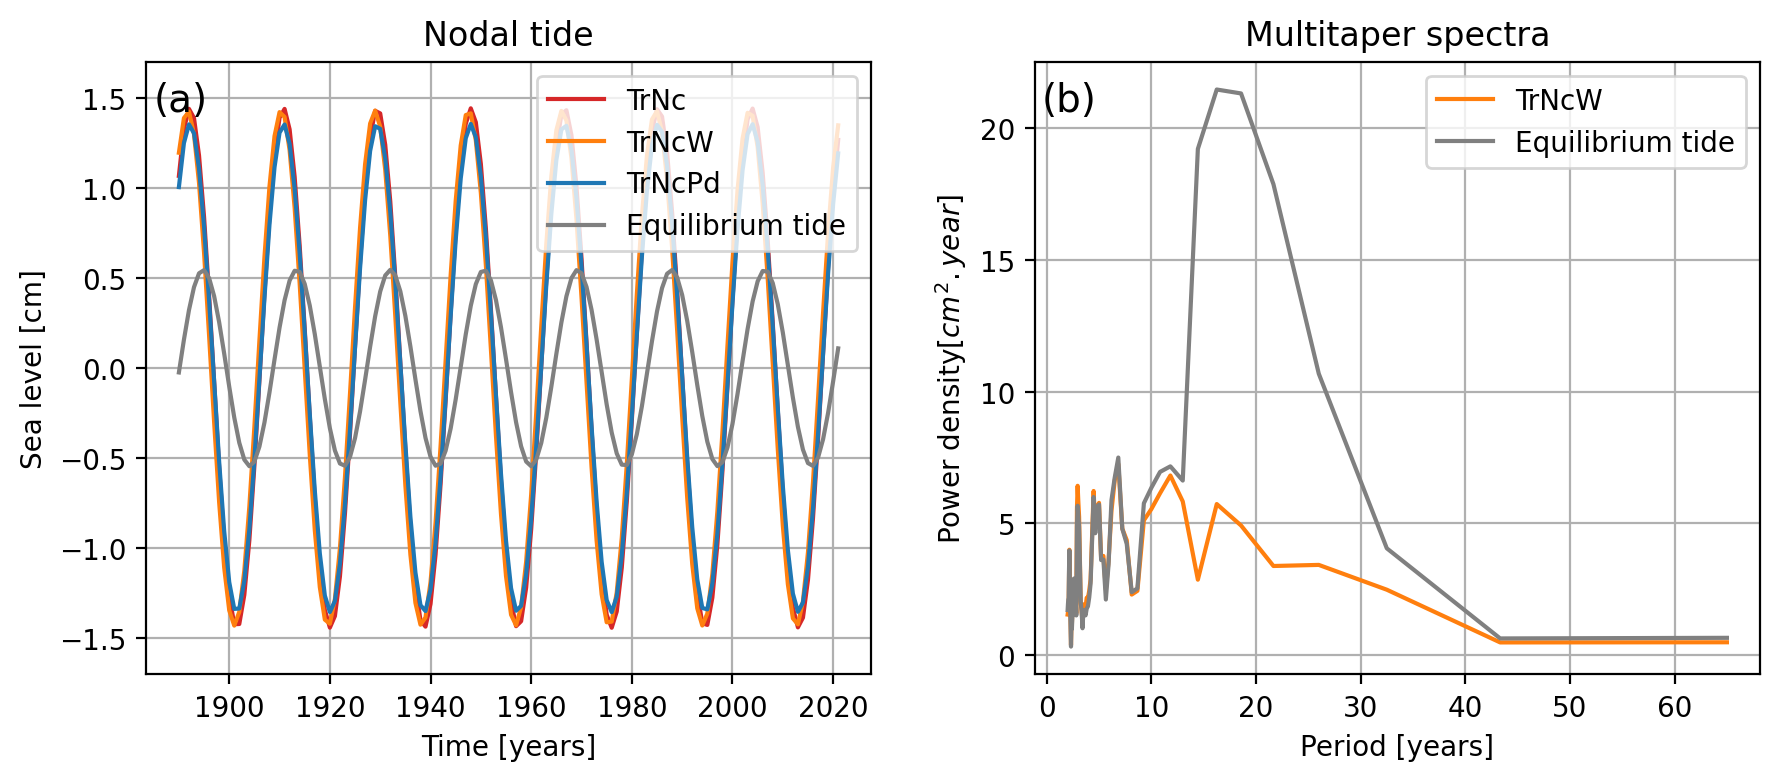

In [122]:
colors = ['tab:red', 'tab:orange', 'tab:blue', 'grey']


fig, ax = plt.subplots(1, 2, figsize=(9,4)) #14, 10

# Panel 1
for idx, data in enumerate(nodal):
    ax[0].plot(nodal.index, nodal[data], label=data, color=colors[idx])

ax[0].set_xlabel('Time [years]')
ax[0].set_ylabel('Sea level [cm]')
ax[0].set_title('Nodal tide')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-1.7,1.7)

# Panel 2
xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['NearestPointAverage2_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm
ax[1].plot(xf_p[2:], yf_mtm[2:], label='TrNcW', color=colors[1])


xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['EquilibriumTide_dt'].values, 1)
ax[1].plot(xf_p[2:], yf_mtm[2:], label='Equilibrium tide', color=colors[3])

ax[1].legend()
ax[1].set_title('Multitaper spectra')
ax[1].set_ylabel('Power density'+r'$[cm^2.year]$')
ax[1].set_xlabel('Period [years]')

for idx in range(2):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()

plt.savefig(f'./figures/{region}/NodalTide.pdf', dpi=150)

## Fig. A2: Low-frequency wind influence on sea level